In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ReduceLROnPlateau
import random
from sklearn.metrics import precision_score, recall_score

In [2]:
train=pd.read_csv('data-training-02.csv')
test=pd.read_csv('data-testing-02.csv')

In [3]:
pd.set_option('display.max_columns', None)
train.head(2)

,weekday_sin,weekday_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M,amt_scaler,cardholder_age_scaler,job_encoded,merchant_encoded,is_fraud
0,-0.781831,0.623490,-2.449294e-16,1.000000,0.998717,-0.050649,-0.707107,-0.707107,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0.004064,0.134146,0.000000,0.001070,0
1,-0.974928,-0.222521,-5.000000e-01,-0.866025,0.937752,0.347305,0.707107,-0.707107,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,0.002857,0.231707,0.010493,0.019666,0


In [4]:
train.shape

(768890, 29)

In [7]:
test.shape

(164170, 29)

In [6]:
X_train = train.drop(columns=['is_fraud'])
X_test = test.drop(columns=['is_fraud'])
y_train = train['is_fraud']
y_test = test['is_fraud']

## find the best parameters

In [14]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import fbeta_score

train20=train.sample(frac = 0.2, random_state=42)
test20=test.sample(frac = 0.2, random_state=42)

X_train_20 = train20.drop(columns=['is_fraud'])
X_test_20 = test20.drop(columns=['is_fraud'])
y_train_20 = train20['is_fraud']
y_test_20 = test20['is_fraud']

def objective(trial):
    num_layers = trial.suggest_int('num_layers', 2, 5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024, 2048])
    neurons = trial.suggest_int('neurons', 16, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    activation = trial.suggest_categorical('activation', ['relu', 'swish', 'tanh'])

    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_dim=X_train.shape[1]))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers - 1):
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['Recall'])

    patience = trial.suggest_int('patience', 3, 7)
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    model.fit(X_train_20, y_train_20, validation_split=0.2, epochs=20, batch_size=batch_size, callbacks=[early_stopping], verbose=0)

    y_pred = (model.predict(X_test_20) > 0.5).astype('int32')
    f2 = fbeta_score(y_test_20, y_pred, beta=2)
    return f2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()


[I 2024-11-24 18:18:53,369] A new study created in memory with name: no-name-81d02695-4191-41a4-8ce3-396743f84e79
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:19:37,866] Trial 0 finished with value: 0.6724683544303798 and parameters: {'num_layers': 2, 'learning_rate': 0.0030018986413795066, 'batch_size': 256, 'neurons': 99, 'dropout_rate': 0.39301506391352437, 'activation': 'tanh', 'patience': 5}. Best is trial 0 with value: 0.6724683544303798.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:20:17,135] Trial 1 finished with value: 0.6403940886699507 and parameters: {'num_layers': 5, 'learning_rate': 0.004278403424764346, 'batch_size': 256, 'neurons': 54, 'dropout_rate': 0.29923120217835153, 'activation': 'tanh', 'patience': 3}. Best is trial 0 with value: 0.6724683544303798.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


[I 2024-11-24 18:20:41,898] Trial 2 finished with value: 0.19898556379243074 and parameters: {'num_layers': 5, 'learning_rate': 0.00010370918872432586, 'batch_size': 2048, 'neurons': 32, 'dropout_rate': 0.46949361463766903, 'activation': 'tanh', 'patience': 4}. Best is trial 0 with value: 0.6724683544303798.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:21:10,829] Trial 3 finished with value: 0.6366585563665855 and parameters: {'num_layers': 3, 'learning_rate': 0.0018351959731284246, 'batch_size': 512, 'neurons': 46, 'dropout_rate': 0.11931785092749628, 'activation': 'relu', 'patience': 5}. Best is trial 0 with value: 0.6724683544303798.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:21:24,125] Trial 4 finished with value: 0.1479076479076479 and parameters: {'num_layers': 2, 'learning_rate': 0.0001142401656923285, 'batch_size': 1024, 'neurons': 17, 'dropout_rate': 0.3874211639588757, 'activation': 'relu', 'patience': 7}. Best is trial 0 with value: 0.6724683544303798.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:21:42,187] Trial 5 finished with value: 0.6672597864768683 and parameters: {'num_layers': 2, 'learning_rate': 0.0019956985690936695, 'batch_size': 1024, 'neurons': 72, 'dropout_rate': 0.48521053427514427, 'activation': 'relu', 'patience': 3}. Best is trial 0 with value: 0.6724683544303798.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:22:10,142] Trial 6 finished with value: 0.25970751386787694 and parameters: {'num_layers': 3, 'learning_rate': 0.0001606302083169261, 'batch_size': 512, 'neurons': 48, 'dropout_rate': 0.49121719904229943, 'activation': 'swish', 'patience': 7}. Best is trial 0 with value: 0.6724683544303798.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:22:34,346] Trial 7 finished with value: 0.289544235924933 and parameters: {'num_layers': 3, 'learning_rate': 0.00023919236618409175, 'batch_size': 2048, 'neurons': 104, 'dropout_rate': 0.22102983897204279, 'activation': 'tanh', 'patience': 6}. Best is trial 0 with value: 0.6724683544303798.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:23:03,401] Trial 8 finished with value: 0.5105853051058531 and parameters: {'num_layers': 5, 'learning_rate': 0.002079663433376176, 'batch_size': 512, 'neurons': 31, 'dropout_rate': 0.4539873320910861, 'activation': 'relu', 'patience': 4}. Best is trial 0 with value: 0.6724683544303798.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:23:37,388] Trial 9 finished with value: 0.25833724753405357 and parameters: {'num_layers': 5, 'learning_rate': 0.0003352444862100624, 'batch_size': 2048, 'neurons': 86, 'dropout_rate': 0.4984797075746792, 'activation': 'tanh', 'patience': 7}. Best is trial 0 with value: 0.6724683544303798.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:24:51,158] Trial 10 finished with value: 0.7007575757575758 and parameters: {'num_layers': 4, 'learning_rate': 0.008625953168262993, 'batch_size': 256, 'neurons': 127, 'dropout_rate': 0.365253013758701, 'activation': 'swish', 'patience': 5}. Best is trial 10 with value: 0.7007575757575758.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


[I 2024-11-24 18:26:01,883] Trial 11 finished with value: 0.6939338235294118 and parameters: {'num_layers': 4, 'learning_rate': 0.008954138374421864, 'batch_size': 256, 'neurons': 127, 'dropout_rate': 0.3600071114239576, 'activation': 'swish', 'patience': 5}. Best is trial 10 with value: 0.7007575757575758.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:27:12,252] Trial 12 finished with value: 0.7319304666056725 and parameters: {'num_layers': 4, 'learning_rate': 0.006701538789048625, 'batch_size': 256, 'neurons': 124, 'dropout_rate': 0.33336538905379004, 'activation': 'swish', 'patience': 6}. Best is trial 12 with value: 0.7319304666056725.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


[I 2024-11-24 18:28:25,545] Trial 13 finished with value: 0.6830122591943958 and parameters: {'num_layers': 4, 'learning_rate': 0.009566443711920352, 'batch_size': 256, 'neurons': 126, 'dropout_rate': 0.2851549647012766, 'activation': 'swish', 'patience': 6}. Best is trial 12 with value: 0.7319304666056725.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:29:33,509] Trial 14 finished with value: 0.6992084432717678 and parameters: {'num_layers': 4, 'learning_rate': 0.0007144255517290964, 'batch_size': 256, 'neurons': 112, 'dropout_rate': 0.22618359530659854, 'activation': 'swish', 'patience': 6}. Best is trial 12 with value: 0.7319304666056725.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:30:39,086] Trial 15 finished with value: 0.7149321266968326 and parameters: {'num_layers': 4, 'learning_rate': 0.004827111991130158, 'batch_size': 256, 'neurons': 113, 'dropout_rate': 0.33846311119155736, 'activation': 'swish', 'patience': 4}. Best is trial 12 with value: 0.7319304666056725.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


[I 2024-11-24 18:31:30,186] Trial 16 finished with value: 0.7112068965517241 and parameters: {'num_layers': 4, 'learning_rate': 0.004789122583465444, 'batch_size': 256, 'neurons': 81, 'dropout_rate': 0.24495890348956811, 'activation': 'swish', 'patience': 4}. Best is trial 12 with value: 0.7319304666056725.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:32:24,899] Trial 17 finished with value: 0.7329842931937173 and parameters: {'num_layers': 3, 'learning_rate': 0.0010752101803145357, 'batch_size': 256, 'neurons': 112, 'dropout_rate': 0.14581447062131933, 'activation': 'swish', 'patience': 4}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:32:53,800] Trial 18 finished with value: 0.4918032786885246 and parameters: {'num_layers': 3, 'learning_rate': 0.0006806481556761717, 'batch_size': 1024, 'neurons': 93, 'dropout_rate': 0.10431483426236485, 'activation': 'swish', 'patience': 6}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:33:49,441] Trial 19 finished with value: 0.712401055408971 and parameters: {'num_layers': 3, 'learning_rate': 0.0011113052399703573, 'batch_size': 256, 'neurons': 114, 'dropout_rate': 0.16672641435595148, 'activation': 'swish', 'patience': 3}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:34:30,680] Trial 20 finished with value: 0.5610687022900763 and parameters: {'num_layers': 3, 'learning_rate': 0.00047490525819742646, 'batch_size': 256, 'neurons': 64, 'dropout_rate': 0.17688245475643244, 'activation': 'swish', 'patience': 5}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:35:38,699] Trial 21 finished with value: 0.6521739130434783 and parameters: {'num_layers': 4, 'learning_rate': 0.00581022356593748, 'batch_size': 256, 'neurons': 114, 'dropout_rate': 0.3380608617681031, 'activation': 'swish', 'patience': 4}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:36:47,438] Trial 22 finished with value: 0.7194244604316546 and parameters: {'num_layers': 4, 'learning_rate': 0.001400004538111158, 'batch_size': 256, 'neurons': 105, 'dropout_rate': 0.42426907973004924, 'activation': 'swish', 'patience': 4}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:37:50,580] Trial 23 finished with value: 0.7302325581395349 and parameters: {'num_layers': 4, 'learning_rate': 0.0011605945774867644, 'batch_size': 256, 'neurons': 103, 'dropout_rate': 0.4160586598912777, 'activation': 'swish', 'patience': 4}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:38:39,179] Trial 24 finished with value: 0.68 and parameters: {'num_layers': 3, 'learning_rate': 0.0007377118230812487, 'batch_size': 256, 'neurons': 91, 'dropout_rate': 0.4243847254629781, 'activation': 'swish', 'patience': 3}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:39:46,536] Trial 25 finished with value: 0.7179054054054054 and parameters: {'num_layers': 4, 'learning_rate': 0.003069825993996291, 'batch_size': 256, 'neurons': 120, 'dropout_rate': 0.27216615416051665, 'activation': 'swish', 'patience': 6}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


[I 2024-11-24 18:40:43,610] Trial 26 finished with value: 0.6826401446654611 and parameters: {'num_layers': 5, 'learning_rate': 0.0011179754051697326, 'batch_size': 512, 'neurons': 102, 'dropout_rate': 0.42704391443400874, 'activation': 'swish', 'patience': 4}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:41:10,725] Trial 27 finished with value: 0.47244094488188976 and parameters: {'num_layers': 3, 'learning_rate': 0.0004909143670170329, 'batch_size': 1024, 'neurons': 74, 'dropout_rate': 0.3229508810509163, 'activation': 'swish', 'patience': 5}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:41:28,343] Trial 28 finished with value: 0.622791519434629 and parameters: {'num_layers': 2, 'learning_rate': 0.0029738958451562404, 'batch_size': 2048, 'neurons': 119, 'dropout_rate': 0.1715978182820947, 'activation': 'relu', 'patience': 3}. Best is trial 17 with value: 0.7329842931937173.
C:\Users\Ragnarok\AppData\Local\Temp\ipykernel_39004\1245596898.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


[I 2024-11-24 18:42:07,011] Trial 29 finished with value: 0.682001614205004 and parameters: {'num_layers': 2, 'learning_rate': 0.003016911161755439, 'batch_size': 256, 'neurons': 96, 'dropout_rate': 0.38204203836212286, 'activation': 'swish', 'patience': 5}. Best is trial 17 with value: 0.7329842931937173.


Best hyperparameters: {'num_layers': 3, 'learning_rate': 0.0010752101803145357, 'batch_size': 256, 'neurons': 112, 'dropout_rate': 0.14581447062131933, 'activation': 'swish', 'patience': 4}


# ANN models

## Model 1

In [15]:

def build_model(input_dim, num_layers, neurons, dropout_rate, activation, learning_rate):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers - 1):
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['Precision', 'Recall'])
    return model

input_dim = X_train.shape[1]  
best_params = {
    'num_layers': 3,
    'neurons': 112,
    'dropout_rate': 0.1458,
    'activation': 'swish',
    'learning_rate': 0.001075,
    'batch_size': 256,
    'patience': 4
}

model = build_model(input_dim, 
                    best_params['num_layers'], 
                    best_params['neurons'], 
                    best_params['dropout_rate'], 
                    best_params['activation'], 
                    best_params['learning_rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=best_params['patience'], restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=best_params['batch_size'],
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

y_pred_probs = model.predict(X_test)  
y_pred_class = (y_pred_probs > 0.5).astype('int32')  

precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f2 = fbeta_score(y_test, y_pred_class, beta=2)
auc = roc_auc_score(y_test, y_pred_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"AUC: {auc:.4f}")


f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - Precision: 0.7661 - Recall: 0.5103 - loss: 0.1706 - val_Precision: 0.9918 - val_Recall: 0.8019 - val_loss: 0.2351 - learning_rate: 0.0011
Epoch 2/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - Precision: 0.9130 - Recall: 0.8036 - loss: 0.0758 - val_Precision: 0.9935 - val_Recall: 0.8528 - val_loss: 0.1787 - learning_rate: 0.0011
Epoch 3/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - Precision: 0.9455 - Recall: 0.8464 - loss: 0.0568 - val_Precision: 0.9940 - val_Recall: 0.8712 - val_loss: 0.1613 - learning_rate: 0.0011
Epoch 4/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - Precision: 0.9621 - Recall: 0.8701 - loss: 0.0464 - val_Precision: 0.9961 - val_Recall: 0.8839 - val_loss: 0.1415 - learning_rate: 0.0011
Epoch 5/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - Precision: 0.9649 - Recall: 0.8827 - loss: 0.0405 - val_Precision: 0.9889 - val_Recall: 0.8813 - val_loss: 0.1616 - learning_rate: 0.0011
Epoch 6/50
2403/2403 ━━━━

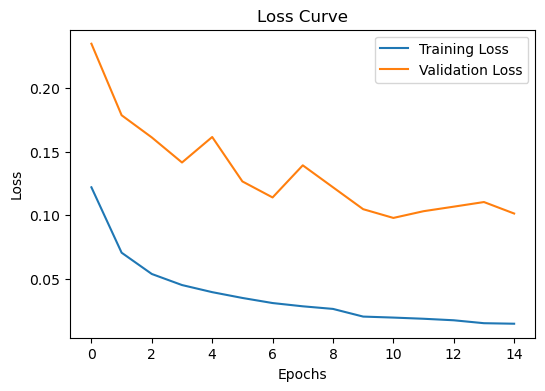

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

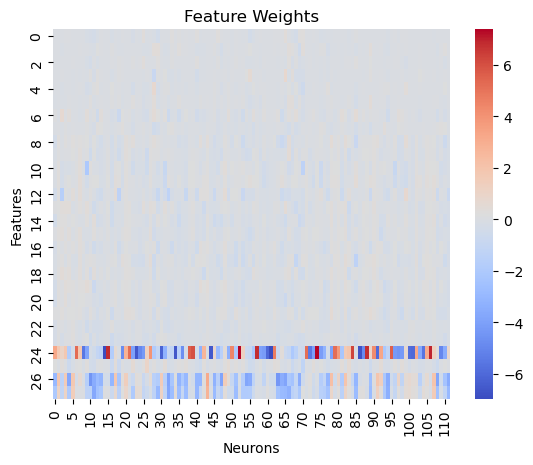

In [18]:
import seaborn as sns
import pandas as pd

weights, biases = model.layers[0].get_weights()

sns.heatmap(weights, cmap='coolwarm')
plt.title('Feature Weights')
plt.xlabel('Neurons')
plt.ylabel('Features')
plt.show()

## Model 2

In [19]:
train=train.drop(['weekday_sin','weekday_cos','month_sin','month_cos','day_sin','day_cos'],axis=1)
test=test.drop(['weekday_sin','weekday_cos','month_sin','month_cos','day_sin','day_cos'],axis=1)

X_train = train.drop(columns=['is_fraud'])
X_test = test.drop(columns=['is_fraud'])
y_train = train['is_fraud']
y_test = test['is_fraud']

def build_model(input_dim, num_layers, neurons, dropout_rate, activation, learning_rate):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers - 1):
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['Precision', 'Recall'])
    return model

input_dim = X_train.shape[1] 
best_params = {
    'num_layers': 3,
    'neurons': 112,
    'dropout_rate': 0.1458,
    'activation': 'swish',
    'learning_rate': 0.001075,
    'batch_size': 256,
    'patience': 4
}

model = build_model(input_dim, 
                    best_params['num_layers'], 
                    best_params['neurons'], 
                    best_params['dropout_rate'], 
                    best_params['activation'], 
                    best_params['learning_rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=best_params['patience'], restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=best_params['batch_size'],
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

y_pred_probs = model.predict(X_test)  
y_pred_class = (y_pred_probs > 0.5).astype('int32') 

precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f2 = fbeta_score(y_test, y_pred_class, beta=2)
auc = roc_auc_score(y_test, y_pred_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - Precision: 0.7958 - Recall: 0.5331 - loss: 0.1654 - val_Precision: 0.9936 - val_Recall: 0.8124 - val_loss: 0.2471 - learning_rate: 0.0011
Epoch 2/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - Precision: 0.9354 - Recall: 0.8135 - loss: 0.0740 - val_Precision: 0.9976 - val_Recall: 0.8307 - val_loss: 0.2243 - learning_rate: 0.0011
Epoch 3/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - Precision: 0.9647 - Recall: 0.8504 - loss: 0.0548 - val_Precision: 0.9978 - val_Recall: 0.8736 - val_loss: 0.1513 - learning_rate: 0.0011
Epoch 4/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - Precision: 0.9757 - Recall: 0.8687 - loss: 0.0456 - val_Precision: 0.9977 - val_Recall: 0.8828 - val_loss: 0.1249 - learning_rate: 0.0011
Epoch 5/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - Precision: 0.9722 - Recall: 0.8793 - loss: 0.0401 - val_Precision: 0.9972 - val_Recall: 0.9080 - val_loss: 0.0925 - learning_rate: 0.0011
Epoch 6/50
2403/2403 ━━━━

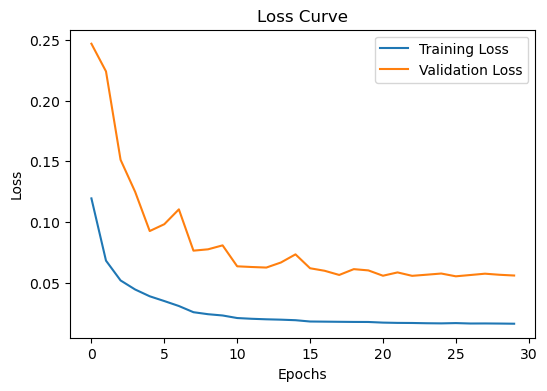

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

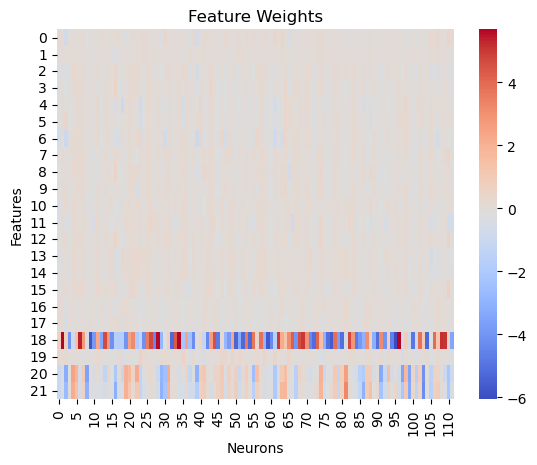

In [21]:
weights, biases = model.layers[0].get_weights()

sns.heatmap(weights, cmap='coolwarm')
plt.title('Feature Weights')
plt.xlabel('Neurons')
plt.ylabel('Features')
plt.show()

## Model 3

In [22]:

def build_model(input_dim, num_layers, neurons, dropout_rate, activation, learning_rate):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers - 1):
        model.add(Dense(neurons, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['Precision', 'Recall'])
    return model

input_dim = X_train.shape[1]  
best_params = {
    'num_layers': 3,
    'neurons': 112,
    'dropout_rate': 0.1458,
    'activation': 'swish',
    'learning_rate': 0.001075,
    'batch_size': 256,
    'patience': 4
}

model = build_model(input_dim, 
                    best_params['num_layers'], 
                    best_params['neurons'], 
                    best_params['dropout_rate'], 
                    best_params['activation'], 
                    best_params['learning_rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=best_params['patience'], restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
class_weights = {0: 1, 1: 5}  # Adjust the weights to make label 1 more important

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=best_params['batch_size'],
                    callbacks=[early_stopping, lr_scheduler],
                    class_weight=class_weights, 
                    verbose=1)

y_pred_probs = model.predict(X_test)  
y_pred_class = (y_pred_probs > 0.5).astype('int32')  

precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f2 = fbeta_score(y_test, y_pred_class, beta=2)
auc = roc_auc_score(y_test, y_pred_probs)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - Precision: 0.5215 - Recall: 0.7990 - loss: 0.3892 - val_Precision: 0.9604 - val_Recall: 0.9049 - val_loss: 0.1471 - learning_rate: 0.0011
Epoch 2/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - Precision: 0.7209 - Recall: 0.9003 - loss: 0.1910 - val_Precision: 0.9744 - val_Recall: 0.9049 - val_loss: 0.1162 - learning_rate: 0.0011
Epoch 3/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - Precision: 0.7866 - Recall: 0.9101 - loss: 0.1473 - val_Precision: 0.9532 - val_Recall: 0.9530 - val_loss: 0.0977 - learning_rate: 0.0011
Epoch 4/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - Precision: 0.8079 - Recall: 0.9223 - loss: 0.1302 - val_Precision: 0.9836 - val_Recall: 0.9107 - val_loss: 0.1041 - learning_rate: 0.0011
Epoch 5/50
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - Precision: 0.8446 - Recall: 0.9399 - loss: 0.1094 - val_Precision: 0.9877 - val_Recall: 0.9529 - val_loss: 0.0715 - learning_rate: 0.0011
Epoch 6/50
2403/2403 ━━━━

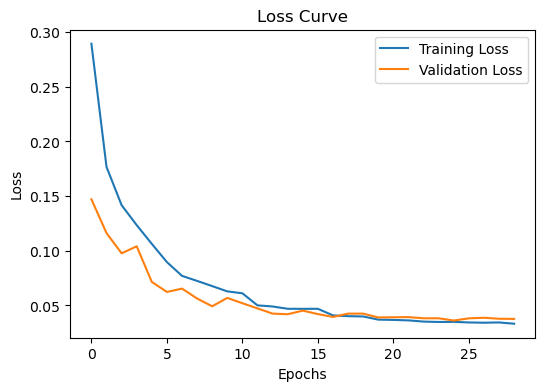

In [23]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Below are some previous attempts, please just ignore them.

In [23]:

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

model = Sequential([
    Dense(128, activation='swish', input_dim=28),
    Dropout(0.4),
    Dense(64, activation='swish'),
    Dropout(0.2),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  
                    callbacks=[early_stopping],
                    verbose=1)

loss, precision, recall = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  

f1 = f1_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred_class, beta=2)

print(f"Test Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"AUC: {auc:.4f}")


f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.2273 - precision: 0.3584 - recall: 0.1204 - val_loss: 0.3261 - val_precision: 0.9865 - val_recall: 0.4796
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0891 - precision: 0.8498 - recall: 0.5160 - val_loss: 0.2536 - val_precision: 0.9931 - val_recall: 0.6106
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0684 - precision: 0.9022 - recall: 0.6450 - val_loss: 0.2063 - val_precision: 0.9907 - val_recall: 0.6944
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0550 - precision: 0.9027 - recall: 0.7386 - val_loss: 0.1639 - val_precision: 0.9902 - val_recall: 0.7807
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0460 - precision: 0.9204 - recall: 0.7927 - val_loss: 0.1421 - val_precision: 0.9926 - val_recall: 0.8073
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0415 - precision: 0.9342 - recall: 0.8133 - val_loss: 0.1164 - val_precision: 0.9928 - val_r

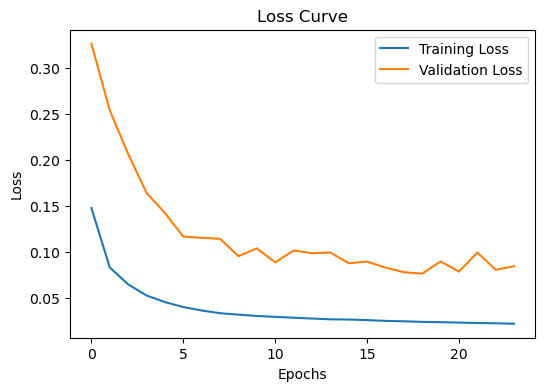

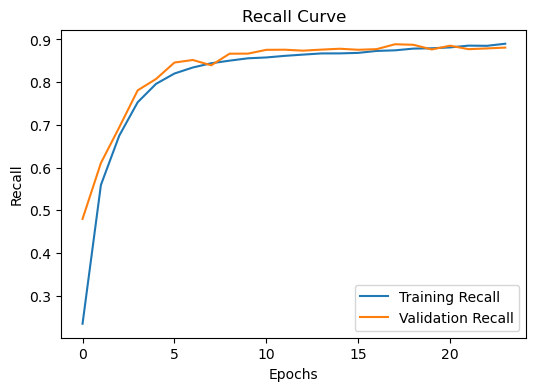

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [107]:
test['is_fraud'].value_counts()

is_fraud
0    163240
1       930
Name: count, dtype: int64

In [108]:
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_115 (Dense)               │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,413 (177.40 KB)

 Trainable params: 15,137 (59.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,276 (118.27 KB)

5131/5131 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


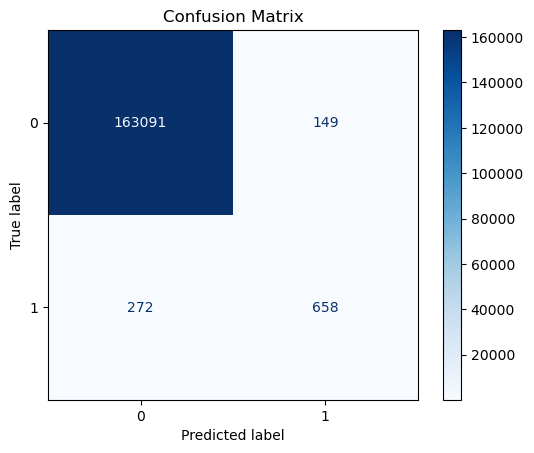

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00    163240
     Class 1       0.82      0.71      0.76       930

    accuracy                           1.00    164170
   macro avg       0.91      0.85      0.88    164170
weighted avg       1.00      1.00      1.00    164170



In [109]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

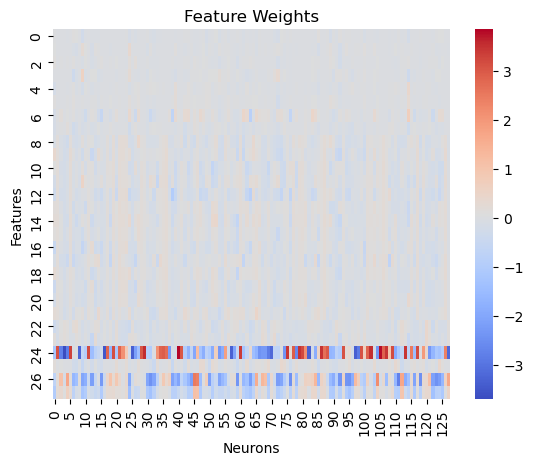

In [110]:
import seaborn as sns
import pandas as pd

weights, biases = model.layers[0].get_weights()

sns.heatmap(weights, cmap='coolwarm')
plt.title('Feature Weights')
plt.xlabel('Neurons')
plt.ylabel('Features')
plt.show()

In [56]:
X_train.head(2)

,weekday_sin,weekday_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M,amt_scaler,cardholder_age_scaler,job_encoded,merchant_encoded
0,-0.781831,0.623490,-2.449294e-16,1.000000,0.998717,-0.050649,-0.707107,-0.707107,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,0.004064,0.134146,0.000000,0.001070
1,-0.974928,-0.222521,-5.000000e-01,-0.866025,0.937752,0.347305,0.707107,-0.707107,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,0.002857,0.231707,0.010493,0.019666


In [6]:
train=train.drop(['weekday_sin','weekday_cos'],axis=1)
test=test.drop(['weekday_sin','weekday_cos'],axis=1)

train=train.drop(['month_sin','month_cos'],axis=1)
test=test.drop(['month_sin','month_cos'],axis=1)

train=train.drop(['day_sin','day_cos'],axis=1)
test=test.drop(['day_sin','day_cos'],axis=1)

X_train = train.drop(columns=['is_fraud'])
X_test = test.drop(columns=['is_fraud'])
y_train = train['is_fraud']
y_test = test['is_fraud']

In [14]:

model = Sequential([
    Dense(128, activation='swish', input_dim=22),
    Dropout(0.4),
    Dense(64, activation='swish'),
    Dropout(0.2),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[Precision(name='precision'), Recall(name='recall')])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,          
    patience=3,          
    verbose=1           
)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024, 
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

loss, precision, recall = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  

f1 = f1_score(y_test, y_pred_class)
f2 = fbeta_score(y_test, y_pred_class, beta=2)
auc = roc_auc_score(y_test, y_pred)

print(f"Test Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"AUC: {auc:.4f}")

Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.2155 - precision: 0.4632 - recall: 0.1086 - val_loss: 0.3094 - val_precision: 0.9918 - val_recall: 0.5502 - learning_rate: 0.0010
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0819 - precision: 0.8972 - recall: 0.5805 - val_loss: 0.2283 - val_precision: 0.9910 - val_recall: 0.6729 - learning_rate: 0.0010
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0617 - precision: 0.9013 - recall: 0.7162 - val_loss: 0.1848 - val_precision: 0.9881 - val_recall: 0.7491 - learning_rate: 0.0010
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0514 - precision: 0.9041 - recall: 0.7873 - val_loss: 0.1665 - val_precision: 0.9896 - val_recall: 0.7589 - learning_rate: 0.0010
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0425 - precision: 0.9240 - recall: 0.8276 - val_loss: 0.1311 - val_precision: 0.9920 - val_recall: 0.8439 - learning_rate: 0.0010
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━

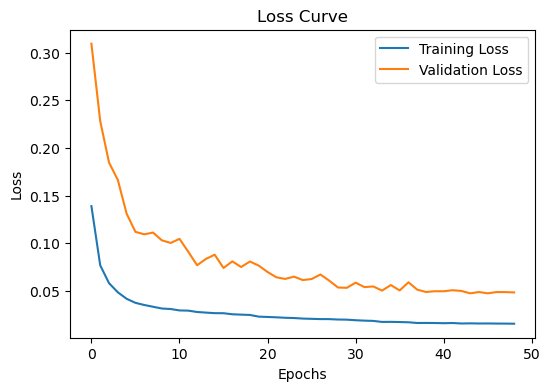

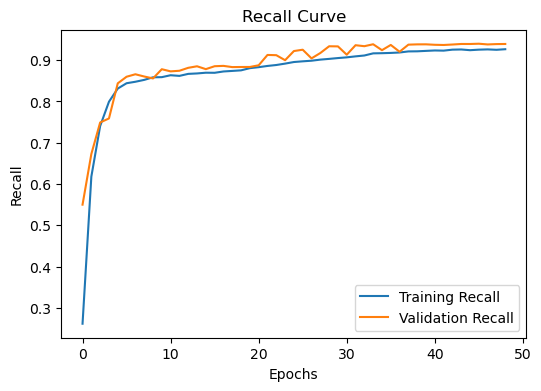

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制 Recall 曲线
plt.figure(figsize=(6, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

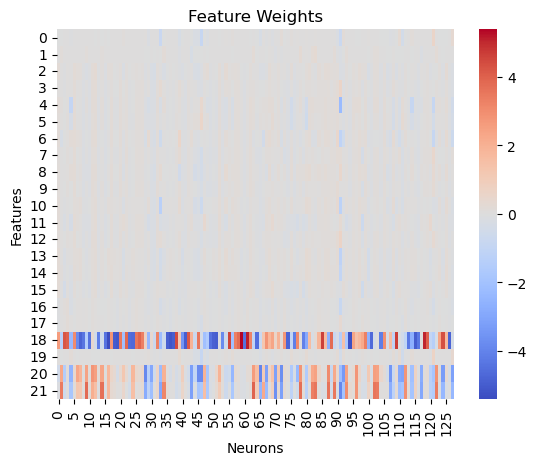

In [191]:
# 获取第一层的权重
weights, biases = model.layers[0].get_weights()

# 可视化权重
sns.heatmap(weights, cmap='coolwarm')
plt.title('Feature Weights')
plt.xlabel('Neurons')
plt.ylabel('Features')
plt.show()

5131/5131 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


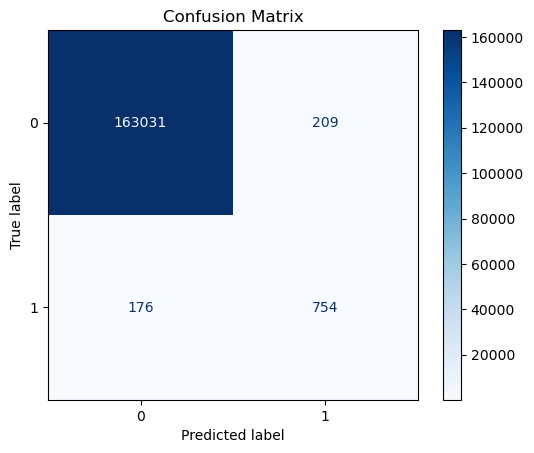

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00    163240
     Class 1       0.78      0.81      0.80       930

    accuracy                           1.00    164170
   macro avg       0.89      0.90      0.90    164170
weighted avg       1.00      1.00      1.00    164170



In [152]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 获取预测值
y_pred = (model.predict(X_test) > 0.5).astype(int)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 打印分类报告
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

In [16]:
#This one is not that stable, but sometimes had higher recall, which is important for identifying fraud. 

model = Sequential([
    Dense(128, activation='swish', input_dim=22),
    Dropout(0.5),
    Dense(64, activation='swish'),
    Dropout(0.3),
    Dense(32, activation='swish'),
    Dropout(0.3),
    Dense(32, activation='swish'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# 定义优化器
optimizer = Adam(learning_rate=0.001)

# 编译模型
model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[Precision(name='precision'), Recall(name='recall')])

# 定义早停回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # 监控验证集损失
    factor=0.5,          # 学习率每次减少的倍率
    patience=3,          # 连续 3 次 val_loss 无改善时减少学习率
    verbose=1            # 输出学习率调整日志
)

class_weights = {0: 1, 1: 5}  # Adjust the weights to make label 1 more important

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 大批量减少内存占用
                    callbacks=[early_stopping,lr_scheduler],
                    class_weight=class_weights, 
                    verbose=1)

# 测试模型
loss, precision, recall = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # 将预测概率转换为类别标签

# 计算 F1 和 AUC
f1 = f1_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred_class, beta=2)

# 输出结果
print(f"Test Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.4487 - precision: 0.3043 - recall: 0.4551 - val_loss: 0.2039 - val_precision: 0.8706 - val_recall: 0.7642 - learning_rate: 0.0010
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2345 - precision: 0.5801 - recall: 0.7565 - val_loss: 0.1508 - val_precision: 0.9300 - val_recall: 0.8396 - learning_rate: 0.0010
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1820 - precision: 0.6964 - recall: 0.8151 - val_loss: 0.1229 - val_precision: 0.9398 - val_recall: 0.8652 - learning_rate: 0.0010
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1506 - precision: 0.7720 - recall: 0.8446 - val_loss: 0.1058 - val_precision: 0.9787 - val_recall: 0.8618 - learning_rate: 0.0010
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1302 - precision: 0.8229 - recall: 0.8593 - val_loss: 0.0961 - val_precision: 0.9761 - val_recall: 0.8768 - learning_rate: 0.0010
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━

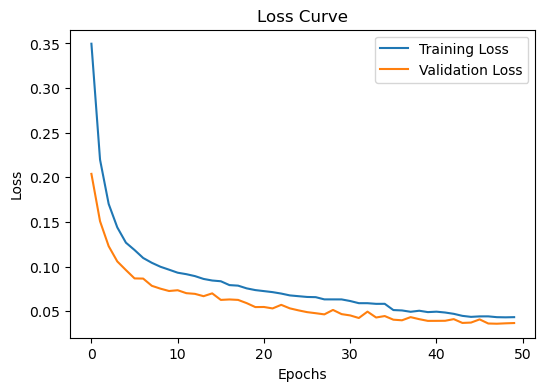

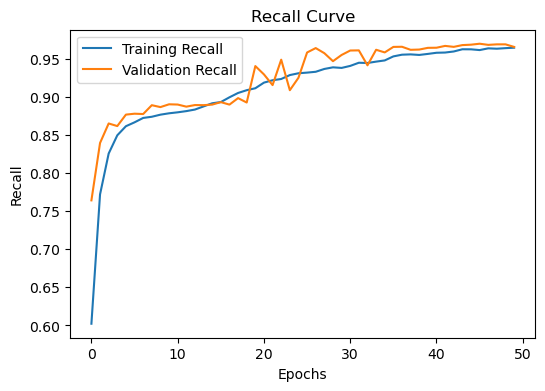

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制 Recall 曲线
plt.figure(figsize=(6, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

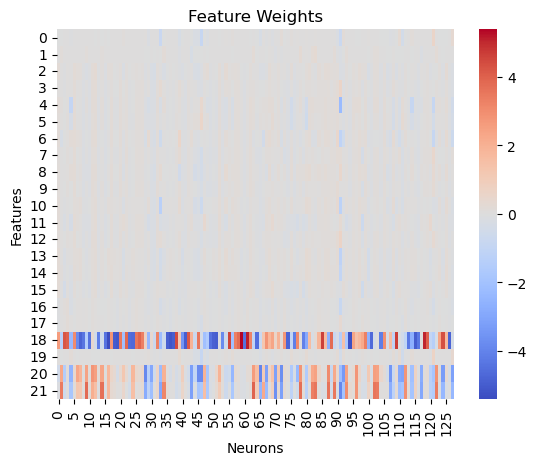

In [192]:
# 获取第一层的权重
weights, biases = model.layers[0].get_weights()

# 可视化权重
sns.heatmap(weights, cmap='coolwarm')
plt.title('Feature Weights')
plt.xlabel('Neurons')
plt.ylabel('Features')
plt.show()

5131/5131 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


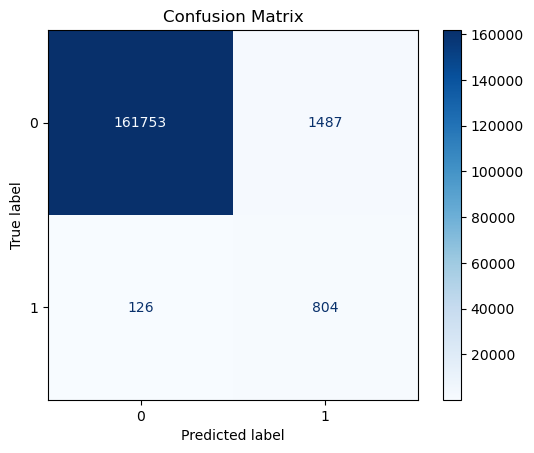

              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00    163240
     Class 1       0.35      0.86      0.50       930

    accuracy                           0.99    164170
   macro avg       0.68      0.93      0.75    164170
weighted avg       1.00      0.99      0.99    164170



In [193]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 获取预测值
y_pred = (model.predict(X_test) > 0.5).astype(int)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 打印分类报告
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

In [79]:
# 定义模型
model = Sequential([
    Dense(128, activation='swish', input_dim=28),
    Dropout(0.4),
    Dense(64, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')
])

# 定义优化器
optimizer = Adam(learning_rate=0.001)

# 编译模型
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[Precision(name='precision'), Recall(name='recall')])

# 定义早停回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 大批量减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, precision, recall = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # 将预测概率转换为类别标签

# 计算 F1 和 AUC
f1 = f1_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred)

# 输出结果
print(f"Test Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.2184 - precision: 0.3523 - recall: 0.1245 - val_loss: 0.3454 - val_precision: 0.9937 - val_recall: 0.4416
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0891 - precision: 0.8645 - recall: 0.5164 - val_loss: 0.2385 - val_precision: 0.9906 - val_recall: 0.6490
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0653 - precision: 0.9031 - recall: 0.6724 - val_loss: 0.1967 - val_precision: 0.9907 - val_recall: 0.7253
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0495 - precision: 0.9160 - recall: 0.7739 - val_loss: 0.1326 - val_precision: 0.9879 - val_recall: 0.8468
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0403 - precision: 0.9347 - recall: 0.8167 - val_loss: 0.1194 - val_precision: 0.9923 - val_recall: 0.8523
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0340 - precision: 0.9485 - recall: 0.8427 - val_loss: 0.1042 - val_precision: 0.9940 - val_recal

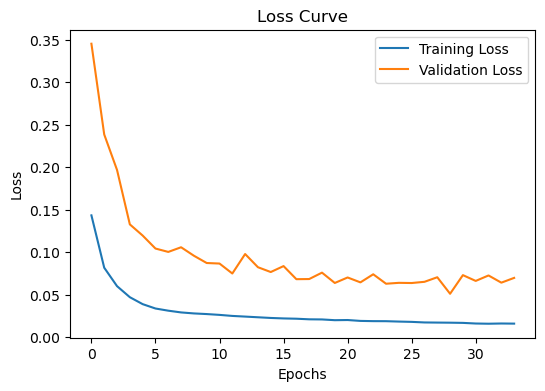

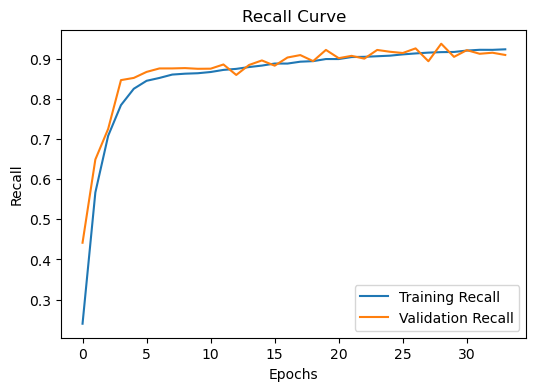

In [82]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制 Recall 曲线
plt.figure(figsize=(6, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [83]:
# 定义模型
model = Sequential([
    Dense(128, activation='swish', input_dim=28),
    Dropout(0.4),
    Dense(64, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')
])

# 定义优化器
optimizer = Adam(learning_rate=0.001)

# 编译模型
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[Precision(name='precision'), Recall(name='recall')])

# 定义早停回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 大批量减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, precision, recall = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # 将预测概率转换为类别标签

# 计算 F1 和 AUC
f1 = f1_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred)

# 输出结果
print(f"Test Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.2098 - precision: 0.4233 - recall: 0.1276 - val_loss: 0.3173 - val_precision: 0.9912 - val_recall: 0.5008
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0864 - precision: 0.8608 - recall: 0.5303 - val_loss: 0.2216 - val_precision: 0.9887 - val_recall: 0.6741
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0633 - precision: 0.9041 - recall: 0.6877 - val_loss: 0.1757 - val_precision: 0.9902 - val_recall: 0.7674
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0512 - precision: 0.9112 - recall: 0.7670 - val_loss: 0.1453 - val_precision: 0.9911 - val_recall: 0.8054
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0425 - precision: 0.9321 - recall: 0.8090 - val_loss: 0.1251 - val_precision: 0.9929 - val_recall: 0.8412
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0370 - precision: 0.9484 - recall: 0.8307 - val_loss: 0.1166 - val_precision: 0.9951 - val_re

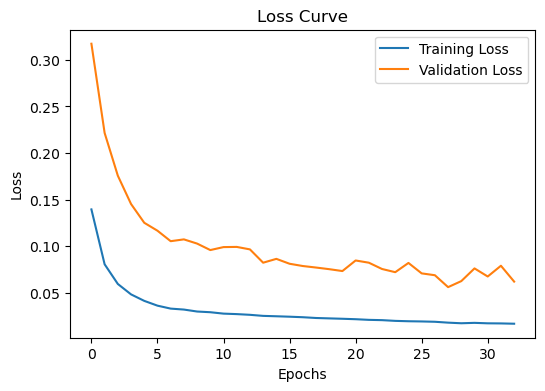

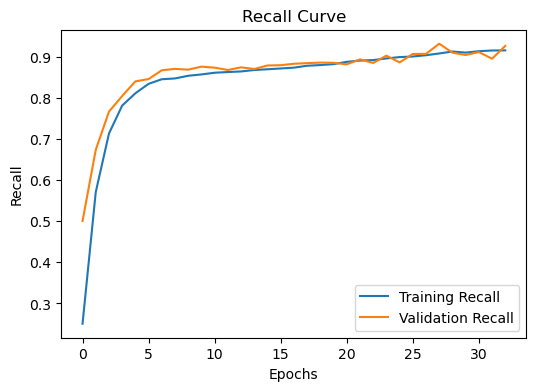

In [84]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制 Recall 曲线
plt.figure(figsize=(6, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [85]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 定义模型
model = Sequential([
    Dense(128, activation='swish', input_dim=28),
    Dropout(0.4),
    Dense(64, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')
])

# 定义优化器
optimizer = Adam(learning_rate=0.001)

# 编译模型
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[Precision(name='precision'), Recall(name='recall')])

# 定义早停回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 定义学习率调度器
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # 监控验证集损失
    factor=0.3,          # 学习率每次减少的倍率
    patience=3,          # 连续 3 次 val_loss 无改善时减少学习率
    verbose=1            # 输出学习率调整日志
)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 大批量减少内存占用
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

# 测试模型
loss, precision, recall = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # 将预测概率转换为类别标签

# 计算 F1 和 AUC
f1 = f1_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred)

# 输出结果
print(f"Test Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.2231 - precision: 0.3955 - recall: 0.1158 - val_loss: 0.3464 - val_precision: 0.9944 - val_recall: 0.4287 - learning_rate: 0.0010
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0882 - precision: 0.8706 - recall: 0.5119 - val_loss: 0.2533 - val_precision: 0.9907 - val_recall: 0.6311 - learning_rate: 0.0010
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0679 - precision: 0.9134 - recall: 0.6501 - val_loss: 0.2312 - val_precision: 0.9914 - val_recall: 0.6559 - learning_rate: 0.0010
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0535 - precision: 0.9018 - recall: 0.7389 - val_loss: 0.1594 - val_precision: 0.9881 - val_recall: 0.7868 - learning_rate: 0.0010
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0443 - precision: 0.9185 - recall: 0.7948 - val_loss: 0.1346 - val_precision: 0.9915 - val_recall: 0.8207 - learning_rate: 0.0010
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━

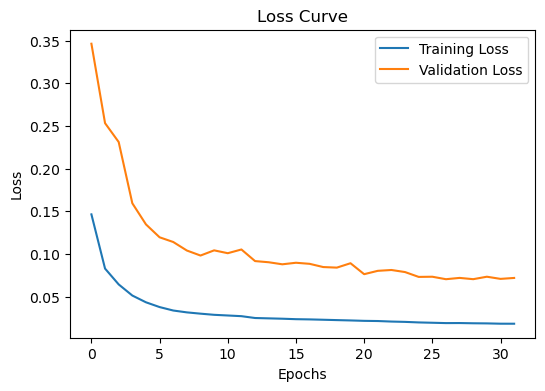

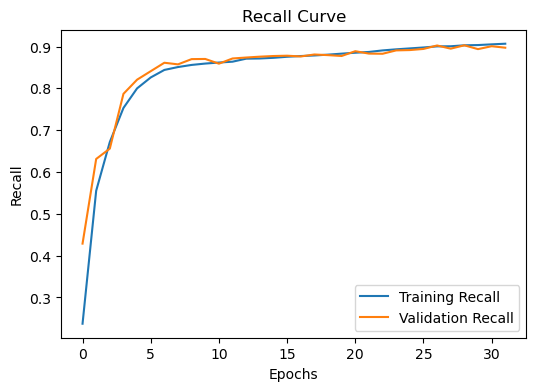

In [86]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制 Recall 曲线
plt.figure(figsize=(6, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [93]:
# 定义模型
model = Sequential([
    Dense(128, activation='swish', input_dim=28),
    Dropout(0.4),
    Dense(64, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# 定义优化器
optimizer = Adam(learning_rate=0.001)

# 编译模型
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[Precision(name='precision'), Recall(name='recall')])

# 定义早停回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 大批量减少内存占用
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

# 测试模型
loss, precision, recall = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # 将预测概率转换为类别标签

# 计算 F1 和 AUC
f1 = f1_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred)

# 输出结果
print(f"Test Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.2311 - precision: 0.3195 - recall: 0.1227 - val_loss: 0.3536 - val_precision: 0.9929 - val_recall: 0.4189 - learning_rate: 0.0010
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0880 - precision: 0.8625 - recall: 0.5160 - val_loss: 0.2453 - val_precision: 0.9933 - val_recall: 0.6197 - learning_rate: 0.0010
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0652 - precision: 0.9071 - recall: 0.6559 - val_loss: 0.1863 - val_precision: 0.9858 - val_recall: 0.7333 - learning_rate: 0.0010
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0519 - precision: 0.9009 - recall: 0.7559 - val_loss: 0.1461 - val_precision: 0.9838 - val_recall: 0.8304 - learning_rate: 0.0010
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0449 - precision: 0.9135 - recall: 0.8012 - val_loss: 0.1335 - val_precision: 0.9912 - val_recall: 0.8328 - learning_rate: 0.0010
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━

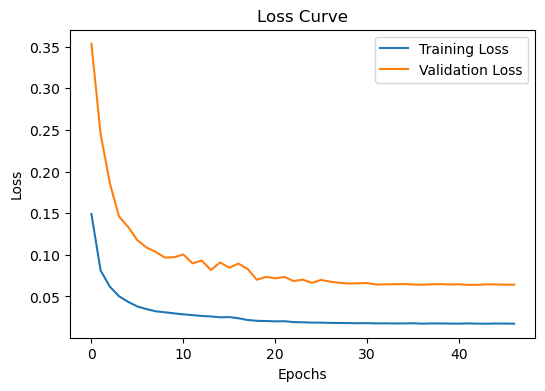

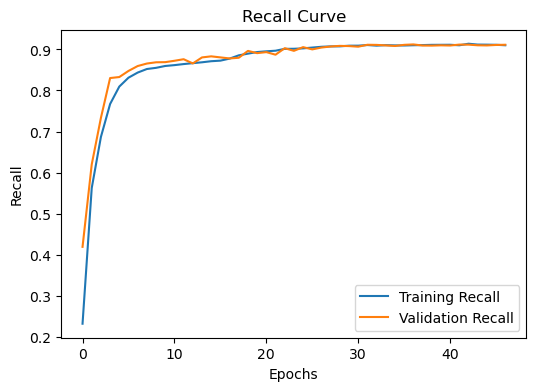

In [94]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制 Recall 曲线
plt.figure(figsize=(6, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [97]:
# 定义模型
model = Sequential([
    Dense(128, activation='swish', input_dim=28),
    Dropout(0.4),
    Dense(64, activation='swish'),
    Dropout(0.2),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# 定义优化器
optimizer = Adam(learning_rate=0.001)

# 编译模型
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[Precision(name='precision'), Recall(name='recall')])

# 定义早停回调函数
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 大批量减少内存占用
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

# 测试模型
loss, precision, recall = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # 将预测概率转换为类别标签

# 计算 F1 和 AUC
f1 = f1_score(y_test, y_pred_class)
auc = roc_auc_score(y_test, y_pred)

# 输出结果
print(f"Test Loss: {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.2203 - precision: 0.3662 - recall: 0.1186 - val_loss: 0.3460 - val_precision: 0.9934 - val_recall: 0.4406 - learning_rate: 0.0010
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0877 - precision: 0.8616 - recall: 0.5205 - val_loss: 0.2437 - val_precision: 0.9913 - val_recall: 0.6500 - learning_rate: 0.0010
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0660 - precision: 0.8951 - recall: 0.6725 - val_loss: 0.1816 - val_precision: 0.9881 - val_recall: 0.7700 - learning_rate: 0.0010
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0523 - precision: 0.9018 - recall: 0.7664 - val_loss: 0.1575 - val_precision: 0.9899 - val_recall: 0.7970 - learning_rate: 0.0010
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0447 - precision: 0.9222 - recall: 0.8025 - val_loss: 0.1345 - val_precision: 0.9932 - val_recall: 0.8299 - learning_rate: 0.0010
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━

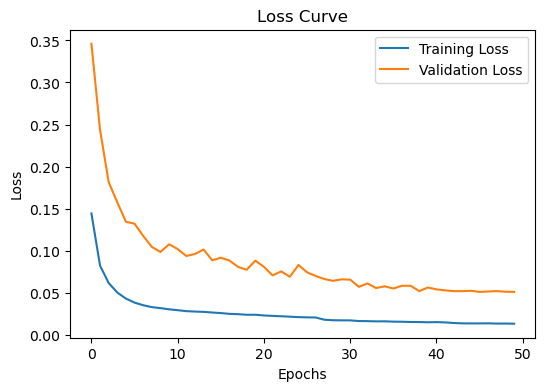

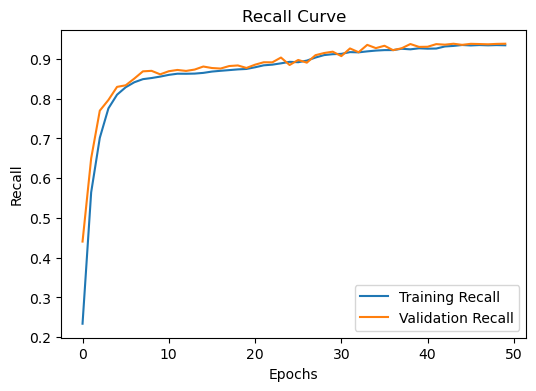

In [98]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制 Recall 曲线
plt.figure(figsize=(6, 4))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [64]:
#This one is not that stable, but sometimes had higher recall, which is important for identifying fraud. 

model = Sequential([
    Dense(128, activation='swish', input_dim=28),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dense(32, activation='swish'),
    Dense(16, activation='swish'),
    Dense(1, activation='sigmoid')          
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class_weights = {0: 1, 1: 5}  # Adjust the weights to make label 1 more important

# training
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  
                    class_weight=class_weights, 
                    callbacks=[early_stopping],
                    verbose=1)

# testing
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9303 - auc_7: 0.8301 - loss: 0.4357 - precision_7: 0.3218 - recall_7: 0.4388 - val_accuracy: 0.9224 - val_auc_7: 0.9612 - val_loss: 0.1992 - val_precision_7: 0.9030 - val_recall_7: 0.7448
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9597 - auc_7: 0.9654 - loss: 0.2138 - precision_7: 0.5636 - recall_7: 0.7622 - val_accuracy: 0.9420 - val_auc_7: 0.9771 - val_loss: 0.1538 - val_precision_7: 0.9435 - val_recall_7: 0.7975
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9713 - auc_7: 0.9810 - loss: 0.1601 - precision_7: 0.6641 - recall_7: 0.8248 - val_accuracy: 0.9563 - val_auc_7: 0.9857 - val_loss: 0.1210 - val_precision_7: 0.9519 - val_recall_7: 0.8545
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9772 - auc_7: 0.9865 - loss: 0.1325 - precision_7: 0.7235 - recall_7: 0.8576 - val_accuracy: 0.9621 - val_auc_7: 0.9892 - val_loss: 0.1004 - val_precision_7: 0.9594 - val

In [65]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,781 (171.02 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,188 (114.02 KB)

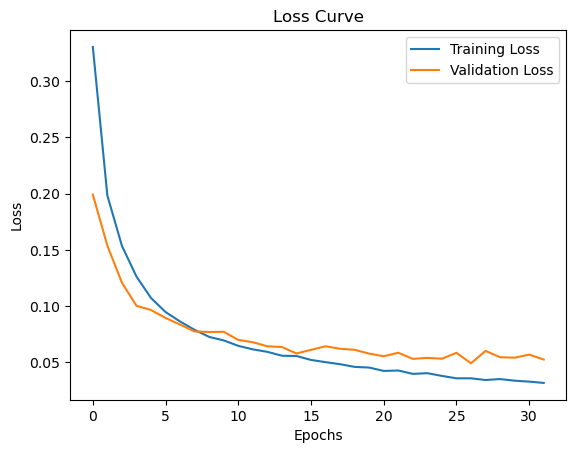

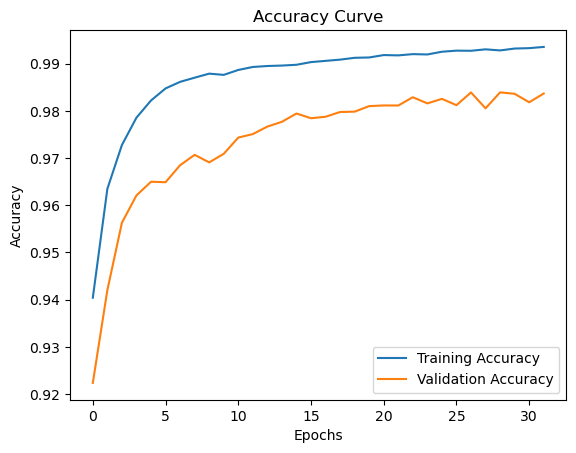

In [66]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制准确率（或其他指标）曲线
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

5131/5131 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


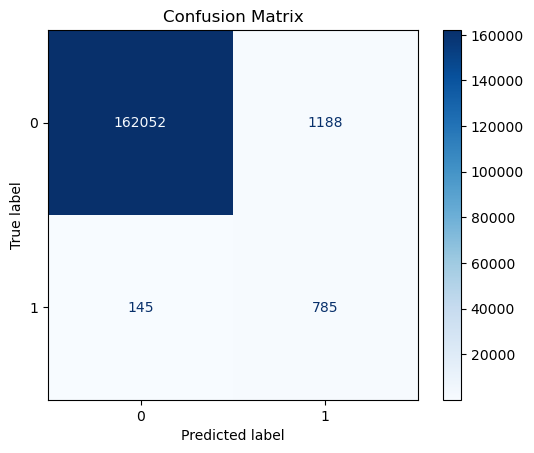

              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00    163240
     Class 1       0.40      0.84      0.54       930

    accuracy                           0.99    164170
   macro avg       0.70      0.92      0.77    164170
weighted avg       1.00      0.99      0.99    164170



In [67]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# 获取预测值
y_pred = (model.predict(X_test) > 0.5).astype(int)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# 打印分类报告
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

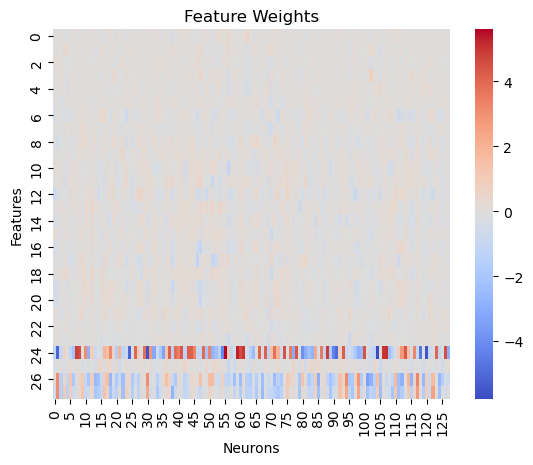

In [68]:
import seaborn as sns
import pandas as pd

# 获取第一层的权重
weights, biases = model.layers[0].get_weights()

# 可视化权重
sns.heatmap(weights, cmap='coolwarm')
plt.title('Feature Weights')
plt.xlabel('Neurons')
plt.ylabel('Features')
plt.show()

In [72]:
#This one is not that stable, but sometimes had higher recall, which is important for identifying fraud. 

model = Sequential([
    Dense(128, activation='swish', input_dim=28),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dropout(0.1),
    Dense(32, activation='swish'),
    Dropout(0.1),
    Dense(16, activation='swish'),
    Dense(1, activation='sigmoid')          
])

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class_weights = {0: 1, 1: 5}  # Adjust the weights to make label 1 more important

# training
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  
                    class_weight=class_weights, 
                    callbacks=[early_stopping],
                    verbose=1)

# testing
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9323 - auc_9: 0.8398 - loss: 0.4292 - precision_9: 0.3281 - recall_9: 0.4490 - val_accuracy: 0.9218 - val_auc_9: 0.9609 - val_loss: 0.1993 - val_precision_9: 0.9002 - val_recall_9: 0.7448
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9592 - auc_9: 0.9653 - loss: 0.2151 - precision_9: 0.5609 - recall_9: 0.7651 - val_accuracy: 0.9430 - val_auc_9: 0.9773 - val_loss: 0.1510 - val_precision_9: 0.9355 - val_recall_9: 0.8099
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9720 - auc_9: 0.9801 - loss: 0.1632 - precision_9: 0.6769 - recall_9: 0.8219 - val_accuracy: 0.9567 - val_auc_9: 0.9854 - val_loss: 0.1173 - val_precision_9: 0.9474 - val_recall_9: 0.8610
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9773 - auc_9: 0.9866 - loss: 0.1310 - precision_9: 0.7258 - recall_9: 0.8591 - val_accuracy: 0.9607 - val_auc_9: 0.9882 - val_loss: 0.1058 - val_precision_9: 0.9685 - val_

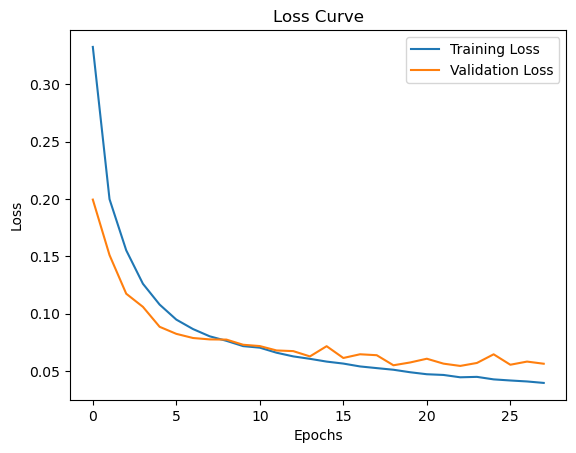

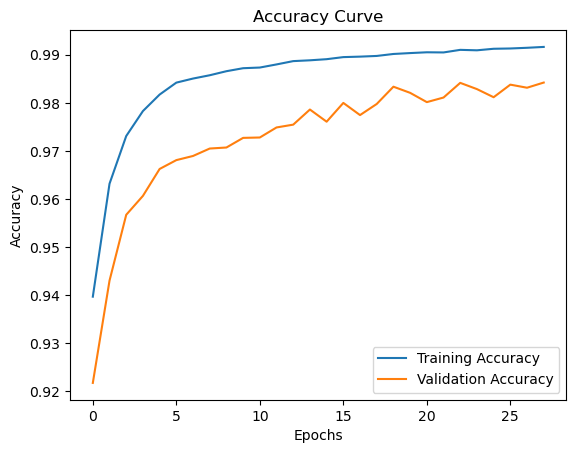

In [73]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制准确率（或其他指标）曲线
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Curve')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [13]:


# 构建模型
model = Sequential([
    Dense(128, activation='relu', input_dim=39),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')           # 输出层
])

# 编译模型，添加其他指标
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")


f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9460 - auc_3: 0.8499 - loss: 0.1834 - precision_3: 0.6676 - recall_3: 0.2914 - val_accuracy: 0.9734 - val_auc_3: 0.9892 - val_loss: 0.0795 - val_precision_3: 0.9629 - val_recall_3: 0.8835
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9898 - auc_3: 0.9947 - loss: 0.0320 - precision_3: 0.9501 - recall_3: 0.8991 - val_accuracy: 0.9706 - val_auc_3: 0.9880 - val_loss: 0.0904 - val_precision_3: 0.9859 - val_recall_3: 0.8458
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9923 - auc_3: 0.9965 - loss: 0.0241 - precision_3: 0.9576 - recall_3: 0.9285 - val_accuracy: 0.9793 - val_auc_3: 0.9899 - val_loss: 0.0675 - val_precision_3: 0.9769 - val_recall_3: 0.9041
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9937 - auc_3: 0.9970 - loss: 0.0199 - precision_3: 0.9635 - recall_3: 0.9432 - val_accuracy: 0.9770 - val_auc_3: 0.9872 - val_loss: 0.0799 - val_precision_3: 0.9872 - val_r

In [15]:


# 构建模型
model = Sequential([
    Dense(128, activation='relu', input_dim=39),
    Dropout(0.5), #有用
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')           # 输出层
])

# 编译模型，添加其他指标
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9346 - auc_4: 0.8227 - loss: 0.2069 - precision_4: 0.5353 - recall_4: 0.1572 - val_accuracy: 0.9539 - val_auc_4: 0.9807 - val_loss: 0.1334 - val_precision_4: 0.9808 - val_recall_4: 0.7540
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9799 - auc_4: 0.9828 - loss: 0.0622 - precision_4: 0.9180 - recall_4: 0.7767 - val_accuracy: 0.9721 - val_auc_4: 0.9882 - val_loss: 0.0868 - val_precision_4: 0.9769 - val_recall_4: 0.8626
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9849 - auc_4: 0.9898 - loss: 0.0469 - precision_4: 0.9295 - recall_4: 0.8438 - val_accuracy: 0.9766 - val_auc_4: 0.9896 - val_loss: 0.0759 - val_precision_4: 0.9762 - val_recall_4: 0.8893
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9869 - auc_4: 0.9921 - loss: 0.0402 - precision_4: 0.9292 - recall_4: 0.8751 - val_accuracy: 0.9765 - val_auc_4: 0.9901 - val_loss: 0.0744 - val_precision_4: 0.9792 - val_r

In [21]:
from tensorflow.keras.optimizers import Adam

# 构建模型
model = Sequential([
    Dense(128, activation='relu', input_dim=39),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001) #有用

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9300 - auc_10: 0.8118 - loss: 0.2108 - precision_10: 0.4659 - recall_10: 0.1468 - val_accuracy: 0.9529 - val_auc_10: 0.9805 - val_loss: 0.1307 - val_precision_10: 0.9794 - val_recall_10: 0.7495
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9800 - auc_10: 0.9842 - loss: 0.0609 - precision_10: 0.9211 - recall_10: 0.7763 - val_accuracy: 0.9721 - val_auc_10: 0.9886 - val_loss: 0.0861 - val_precision_10: 0.9768 - val_recall_10: 0.8625
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9859 - auc_10: 0.9916 - loss: 0.0435 - precision_10: 0.9332 - recall_10: 0.8587 - val_accuracy: 0.9738 - val_auc_10: 0.9887 - val_loss: 0.0850 - val_precision_10: 0.9815 - val_recall_10: 0.8684
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9871 - auc_10: 0.9933 - loss: 0.0386 - precision_10: 0.9294 - recall_10: 0.8798 - val_accuracy: 0.9771 - val_auc_10: 0.9912 - val_loss: 0.0718 - val_prec

In [22]:
# 构建模型
model = Sequential([
    Dense(128, activation='relu', input_dim=39),
    Dropout(0.3), #有提升但不多
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9291 - auc_11: 0.8168 - loss: 0.2093 - precision_11: 0.4913 - recall_11: 0.1938 - val_accuracy: 0.9611 - val_auc_11: 0.9845 - val_loss: 0.1146 - val_precision_11: 0.9820 - val_recall_11: 0.7944
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9824 - auc_11: 0.9876 - loss: 0.0524 - precision_11: 0.9214 - recall_11: 0.8123 - val_accuracy: 0.9691 - val_auc_11: 0.9879 - val_loss: 0.0958 - val_precision_11: 0.9843 - val_recall_11: 0.8385
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9868 - auc_11: 0.9930 - loss: 0.0392 - precision_11: 0.9283 - recall_11: 0.8763 - val_accuracy: 0.9778 - val_auc_11: 0.9906 - val_loss: 0.0720 - val_precision_11: 0.9708 - val_recall_11: 0.9014
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9890 - auc_11: 0.9942 - loss: 0.0331 - precision_11: 0.9352 - recall_11: 0.9010 - val_accuracy: 0.9732 - val_auc_11: 0.9879 - val_loss: 0.0882 - val_pre

In [28]:
# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9304 - auc_14: 0.8161 - loss: 0.2209 - precision_14: 0.5509 - recall_14: 0.2433 - val_accuracy: 0.9434 - val_auc_14: 0.9748 - val_loss: 0.1610 - val_precision_14: 0.9883 - val_recall_14: 0.6881
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9769 - auc_14: 0.9765 - loss: 0.0722 - precision_14: 0.9067 - recall_14: 0.7431 - val_accuracy: 0.9622 - val_auc_14: 0.9856 - val_loss: 0.1079 - val_precision_14: 0.9745 - val_recall_14: 0.8074
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9822 - auc_14: 0.9876 - loss: 0.0537 - precision_14: 0.9157 - recall_14: 0.8168 - val_accuracy: 0.9706 - val_auc_14: 0.9910 - val_loss: 0.0817 - val_precision_14: 0.9705 - val_recall_14: 0.8597
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9846 - auc_14: 0.9915 - loss: 0.0445 - precision_14: 0.9179 - recall_14: 0.8524 - val_accuracy: 0.9752 - val_auc_14: 0.9922 - val_loss: 0.0724 - val_pre

In [10]:


# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=2048,  # 使用大批次以减少内存占用 #效果不好 还是1024
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9342 - auc_3: 0.7230 - loss: 0.2733 - precision_3: 0.5043 - recall_3: 0.1163 - val_accuracy: 0.9185 - val_auc_3: 0.9470 - val_loss: 0.2228 - val_precision_3: 0.9823 - val_recall_3: 0.5486
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9672 - auc_3: 0.9562 - loss: 0.0984 - precision_3: 0.8794 - recall_3: 0.6095 - val_accuracy: 0.9504 - val_auc_3: 0.9757 - val_loss: 0.1469 - val_precision_3: 0.9836 - val_recall_3: 0.7312
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9782 - auc_3: 0.9765 - loss: 0.0699 - precision_3: 0.9177 - recall_3: 0.7491 - val_accuracy: 0.9590 - val_auc_3: 0.9830 - val_loss: 0.1218 - val_precision_3: 0.9798 - val_recall_3: 0.7841
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9817 - auc_3: 0.9847 - loss: 0.0579 - precision_3: 0.9233 - recall_3: 0.7977 - val_accuracy: 0.9631 - val_auc_3: 0.9878 - val_loss: 0.1032 - val_precision_3: 0.9785 - 

In [15]:
# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dropout(0.3),  #有用
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.9324 - auc_5: 0.8087 - loss: 0.2261 - precision_5: 0.5501 - recall_5: 0.2214 - val_accuracy: 0.9500 - val_auc_5: 0.9730 - val_loss: 0.1473 - val_precision_5: 0.9801 - val_recall_5: 0.7318
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9768 - auc_5: 0.9742 - loss: 0.0740 - precision_5: 0.9116 - recall_5: 0.7325 - val_accuracy: 0.9600 - val_auc_5: 0.9841 - val_loss: 0.1165 - val_precision_5: 0.9775 - val_recall_5: 0.7921
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9816 - auc_5: 0.9849 - loss: 0.0572 - precision_5: 0.9103 - recall_5: 0.8123 - val_accuracy: 0.9669 - val_auc_5: 0.9893 - val_loss: 0.0943 - val_precision_5: 0.9734 - val_recall_5: 0.8354
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9842 - auc_5: 0.9894 - loss: 0.0471 - precision_5: 0.9123 - recall_5: 0.8511 - val_accuracy: 0.9729 - val_auc_5: 0.9915 - val_loss: 0.0799 - val_precision_5: 0.9741 - 

In [17]:
# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dropout(0.3),
    Dense(32, activation='swish'),
    Dropout(0.3),  #加了之后表现没有之前好
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9348 - auc_7: 0.8028 - loss: 0.2236 - precision_7: 0.5704 - recall_7: 0.2383 - val_accuracy: 0.9458 - val_auc_7: 0.9727 - val_loss: 0.1572 - val_precision_7: 0.9851 - val_recall_7: 0.7040
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9765 - auc_7: 0.9715 - loss: 0.0769 - precision_7: 0.9086 - recall_7: 0.7296 - val_accuracy: 0.9573 - val_auc_7: 0.9839 - val_loss: 0.1272 - val_precision_7: 0.9818 - val_recall_7: 0.7728
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9816 - auc_7: 0.9846 - loss: 0.0576 - precision_7: 0.9095 - recall_7: 0.8130 - val_accuracy: 0.9681 - val_auc_7: 0.9894 - val_loss: 0.0934 - val_precision_7: 0.9749 - val_recall_7: 0.8412
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9839 - auc_7: 0.9879 - loss: 0.0496 - precision_7: 0.9103 - recall_7: 0.8481 - val_accuracy: 0.9738 - val_auc_7: 0.9917 - val_loss: 0.0768 - val_precision_7: 0.9668 - 

In [20]:
# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.3),
    Dense(128, activation='swish'), #有点改进但效果不大
    Dropout(0.3),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9300 - auc_9: 0.8221 - loss: 0.2162 - precision_9: 0.5566 - recall_9: 0.2536 - val_accuracy: 0.9516 - val_auc_9: 0.9742 - val_loss: 0.1464 - val_precision_9: 0.9820 - val_recall_9: 0.7396
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9774 - auc_9: 0.9751 - loss: 0.0722 - precision_9: 0.9110 - recall_9: 0.7447 - val_accuracy: 0.9648 - val_auc_9: 0.9872 - val_loss: 0.1001 - val_precision_9: 0.9718 - val_recall_9: 0.8247
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9826 - auc_9: 0.9868 - loss: 0.0528 - precision_9: 0.9091 - recall_9: 0.8265 - val_accuracy: 0.9702 - val_auc_9: 0.9905 - val_loss: 0.0869 - val_precision_9: 0.9718 - val_recall_9: 0.8562
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9845 - auc_9: 0.9904 - loss: 0.0451 - precision_9: 0.9123 - recall_9: 0.8560 - val_accuracy: 0.9745 - val_auc_9: 0.9917 - val_loss: 0.0757 - val_precision_9: 0.9720 - 

In [23]:
# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.3),
    Dense(128, activation='swish'),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9340 - auc_12: 0.8259 - loss: 0.2145 - precision_12: 0.5800 - recall_12: 0.2703 - val_accuracy: 0.9508 - val_auc_12: 0.9739 - val_loss: 0.1497 - val_precision_12: 0.9805 - val_recall_12: 0.7362
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9773 - auc_12: 0.9759 - loss: 0.0711 - precision_12: 0.9056 - recall_12: 0.7470 - val_accuracy: 0.9628 - val_auc_12: 0.9849 - val_loss: 0.1116 - val_precision_12: 0.9734 - val_recall_12: 0.8116
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9825 - auc_12: 0.9866 - loss: 0.0527 - precision_12: 0.9074 - recall_12: 0.8317 - val_accuracy: 0.9689 - val_auc_12: 0.9898 - val_loss: 0.0891 - val_precision_12: 0.9746 - val_recall_12: 0.8459
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9851 - auc_12: 0.9912 - loss: 0.0436 - precision_12: 0.9197 - recall_12: 0.8589 - val_accuracy: 0.9749 - val_auc_12: 0.9926 - val_loss: 0.0703 - val_

In [25]:
# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dense(32, activation='swish'),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9387 - auc_14: 0.8180 - loss: 0.2218 - precision_14: 0.6205 - recall_14: 0.2535 - val_accuracy: 0.9406 - val_auc_14: 0.9744 - val_loss: 0.1697 - val_precision_14: 0.9903 - val_recall_14: 0.6705
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9777 - auc_14: 0.9787 - loss: 0.0690 - precision_14: 0.9139 - recall_14: 0.7480 - val_accuracy: 0.9677 - val_auc_14: 0.9877 - val_loss: 0.0924 - val_precision_14: 0.9662 - val_recall_14: 0.8472
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9829 - auc_14: 0.9886 - loss: 0.0505 - precision_14: 0.9100 - recall_14: 0.8335 - val_accuracy: 0.9743 - val_auc_14: 0.9923 - val_loss: 0.0734 - val_precision_14: 0.9670 - val_recall_14: 0.8848
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9856 - auc_14: 0.9924 - loss: 0.0411 - precision_14: 0.9197 - recall_14: 0.8681 - val_accuracy: 0.9766 - val_auc_14: 0.9928 - val_loss: 0.0667 - val_pre

In [26]:
# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.5),
    Dense(64, activation='swish'),
    Dropout(0.3), #不dropout会好一些
    Dense(32, activation='swish'),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9283 - auc_15: 0.7904 - loss: 0.2405 - precision_15: 0.5122 - recall_15: 0.2060 - val_accuracy: 0.9452 - val_auc_15: 0.9675 - val_loss: 0.1628 - val_precision_15: 0.9853 - val_recall_15: 0.7007
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9756 - auc_15: 0.9699 - loss: 0.0778 - precision_15: 0.9049 - recall_15: 0.7226 - val_accuracy: 0.9608 - val_auc_15: 0.9788 - val_loss: 0.1249 - val_precision_15: 0.9749 - val_recall_15: 0.7990
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9819 - auc_15: 0.9831 - loss: 0.0574 - precision_15: 0.9032 - recall_15: 0.8247 - val_accuracy: 0.9704 - val_auc_15: 0.9895 - val_loss: 0.0897 - val_precision_15: 0.9663 - val_recall_15: 0.8628
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9839 - auc_15: 0.9886 - loss: 0.0479 - precision_15: 0.9080 - recall_15: 0.8495 - val_accuracy: 0.9736 - val_auc_15: 0.9924 - val_loss: 0.0740 - val_pre

In [29]:
# 构建模型
model = Sequential([
    Dense(128, activation='swish', kernel_regularizer=l2(0.001), input_dim=39),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dense(32, activation='swish'),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])

# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9357 - auc_18: 0.8226 - loss: 0.2577 - precision_18: 0.5868 - recall_18: 0.2279 - val_accuracy: 0.9457 - val_auc_18: 0.9717 - val_loss: 0.1785 - val_precision_18: 0.9887 - val_recall_18: 0.7010
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9768 - auc_18: 0.9748 - loss: 0.0908 - precision_18: 0.9184 - recall_18: 0.7287 - val_accuracy: 0.9649 - val_auc_18: 0.9863 - val_loss: 0.1182 - val_precision_18: 0.9804 - val_recall_18: 0.8180
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9827 - auc_18: 0.9845 - loss: 0.0673 - precision_18: 0.9235 - recall_18: 0.8162 - val_accuracy: 0.9719 - val_auc_18: 0.9884 - val_loss: 0.0975 - val_precision_18: 0.9644 - val_recall_18: 0.8732
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9842 - auc_18: 0.9876 - loss: 0.0594 - precision_18: 0.9203 - recall_18: 0.8441 - val_accuracy: 0.9710 - val_auc_18: 0.9913 - val_loss: 0.0932 - val_pre

In [30]:
# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dense(32, activation='swish'),
    Dense(32, activation='swish'),
    Dense(16, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])


# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9382 - auc_19: 0.7983 - loss: 0.2302 - precision_19: 0.5982 - recall_19: 0.2420 - val_accuracy: 0.9466 - val_auc_19: 0.9751 - val_loss: 0.1534 - val_precision_19: 0.9864 - val_recall_19: 0.7075
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9783 - auc_19: 0.9778 - loss: 0.0684 - precision_19: 0.9095 - recall_19: 0.7604 - val_accuracy: 0.9655 - val_auc_19: 0.9875 - val_loss: 0.1005 - val_precision_19: 0.9736 - val_recall_19: 0.8270
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9831 - auc_19: 0.9880 - loss: 0.0497 - precision_19: 0.9092 - recall_19: 0.8373 - val_accuracy: 0.9734 - val_auc_19: 0.9914 - val_loss: 0.0771 - val_precision_19: 0.9686 - val_recall_19: 0.8778
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9856 - auc_19: 0.9918 - loss: 0.0411 - precision_19: 0.9186 - recall_19: 0.8687 - val_accuracy: 0.9767 - val_auc_19: 0.9917 - val_loss: 0.0705 - val_pre

In [39]:

# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dense(32, activation='swish'),
    Dense(32, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])

# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class_weights = {0: 1, 1: 10}  # 调整权重，让类别 1 更重要

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    class_weight=class_weights, 
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8721 - auc_20: 0.8957 - loss: 0.6282 - precision_20: 0.3198 - recall_20: 0.7319 - val_accuracy: 0.9519 - val_auc_20: 0.9829 - val_loss: 0.1301 - val_precision_20: 0.8352 - val_recall_20: 0.9065
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9489 - auc_20: 0.9834 - loss: 0.2605 - precision_20: 0.5821 - recall_20: 0.9158 - val_accuracy: 0.9607 - val_auc_20: 0.9898 - val_loss: 0.1083 - val_precision_20: 0.8474 - val_recall_20: 0.9481
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9623 - auc_20: 0.9915 - loss: 0.1843 - precision_20: 0.6582 - recall_20: 0.9477 - val_accuracy: 0.9619 - val_auc_20: 0.9924 - val_loss: 0.1024 - val_precision_20: 0.8449 - val_recall_20: 0.9609
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9682 - auc_20: 0.9940 - loss: 0.1532 - precision_20: 0.6950 - recall_20: 0.9571 - val_accuracy: 0.9723 - val_auc_20: 0.9945 - val_loss: 0.0763 - val_pre

In [42]:

# 构建模型
model = Sequential([
    Dense(128, activation='swish', input_dim=39),
    Dropout(0.3),
    Dense(64, activation='swish'),
    Dense(32, activation='swish'),
    Dense(16, activation='swish'),
    Dense(1, activation='sigmoid')           # 输出层
])

# 编译模型，添加其他指标
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), AUC()])

# 定义早停机制以防止过拟合
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class_weights = {0: 1, 1: 10}  # 调整权重，让类别 1 更重要

# 训练模型
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=1024,  # 使用大批次以减少内存占用
                    class_weight=class_weights, 
                    callbacks=[early_stopping],
                    verbose=1)

# 测试模型
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"AUC: {auc:.4f}")

f:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8641 - auc_22: 0.9014 - loss: 0.6253 - precision_22: 0.3200 - recall_22: 0.7740 - val_accuracy: 0.9530 - val_auc_22: 0.9838 - val_loss: 0.1282 - val_precision_22: 0.8412 - val_recall_22: 0.9047
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9521 - auc_22: 0.9848 - loss: 0.2482 - precision_22: 0.5980 - recall_22: 0.9206 - val_accuracy: 0.9703 - val_auc_22: 0.9907 - val_loss: 0.0913 - val_precision_22: 0.9001 - val_recall_22: 0.9357
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9650 - auc_22: 0.9915 - loss: 0.1819 - precision_22: 0.6747 - recall_22: 0.9471 - val_accuracy: 0.9712 - val_auc_22: 0.9930 - val_loss: 0.0790 - val_precision_22: 0.8951 - val_recall_22: 0.9483
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9696 - auc_22: 0.9940 - loss: 0.1504 - precision_22: 0.7034 - recall_22: 0.9600 - val_accuracy: 0.9684 - val_auc_22: 0.9941 - val_loss: 0.0856 - val_pre

5131/5131 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


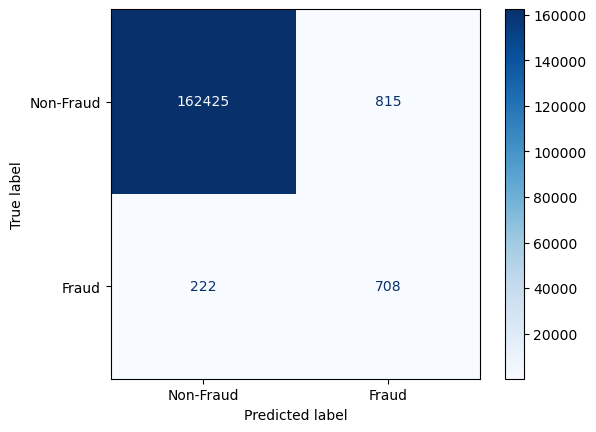

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 模型预测
y_pred = model.predict(X_test)
y_pred_classes = (y_pred >= 0.5).astype(int)  # 将概率转为类别

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
disp.plot(cmap='Blues')